In [ ]:
import pathlib
import torchvision
import torch
from torchvision import transforms
import PIL
import numpy as np
from PIL import Image, ImageSequence, ImageOps
from pathlib import Path
import pandas as pd

# Defining preprocessing functions

Below, we define some functions for preprocessing grayscale images.

In [2]:
def invertedGrayscaleFrames(gif) -> list:
    listOfFrames = []
    for frame in ImageSequence.Iterator(gif):
        listOfFrames.append(ImageOps.invert(frame.convert('L')))
    return listOfFrames


def processGrayscale(gif, targetSize, cropFactor):
    listOfFrames = []
    for frame in ImageSequence.Iterator(gif):
        listOfFrames.append(ImageOps.invert(frame.convert('L')))
    w, h = gif.size
    cropLimits = [cropFactor*w, cropFactor*h, 
                        w-cropFactor*w, h-cropFactor*h]
    return [frame.crop(cropLimits).resize(targetSize)
                        for frame in listOfFrames]

def setGrayFrames(imageList, frames):
    if len(imageList) == frames:
        return imageList
    if len(imageList) > frames:
        return imageList[0:frames]
    size = imageList[0].size
    whiteImage =  white_image = Image.new('L', size, 255)
    return imageList+[whiteImage]*(frames - len(imageList))

def setNumGrayTensors(listOfTensors, numTensors, tensorizor, grayVal: int ):
    n = len(listOfTensors)
    if n >= numTensors:
        return listOfTensors[0:numTensors]
    
    size = (listOfTensors[0].shape[1], listOfTensors[0].shape[2])
    solidTensor = tensorizor(Image.new('L', size, color=grayVal))
    return listOfTensors+[solidTensor.float()]*(numTensors - n)

Below, we define some functions for processing color images.

In [3]:
def listOfFrames(image):
    listOfFrames = []
    for frame in range(image.n_frames):
        image.seek(frame)
        listOfFrames.append(im.convert('RGB'))
    return listOfFrames

def resizeAndCropColor(listOfFrames, targetSize, cropFactor):
    resizedFrames = []
    w, h = listOfFrames[0].size
    cropLimits = [cropFactor*w, cropFactor*h, 
                        w-cropFactor*w, h-cropFactor*h]
    return [frame.crop(cropLimits).resize(targetSize)
                        for frame in listOfFrames]

def padOrChopFrames(listOfFrames, targetFrames):
    n = len(listOfFrames)
    if n >= targetFrames:
        return listOfFrames[0:targetFrames]
    else:
        pad =Image.new('RGB', listOfFrames[0].size)
        return [listOfFrames[i] if i < n else pad for i in range(targetFrames)]

def mirrorFrames(listOfFrames):
    return [ImageOps.mirror(frame) for frame in listOfFrames]

def tensorizeFrames(tensorizor, listOfFrames):
    return [tensorizor(frame) for frame in listOfFrames]

## The following turns raw images into processed images and saves them

First we decide on a path to a folder where we will save our processed images.

In [4]:
homeDir = Path()
processedGrayscaleImageFolder = 'processedGrayscaleImages'
proceessedColorImageFolder = 'processedColorImages'

processedGrayscaleImageDir = homeDir / processedGrayscaleImageFolder
processedColorImageDir = homeDir / proceessedColorImageFolder

processedGrayscaleImageDir.resolve().mkdir(parents=True, exist_ok=True)
processedColorImageDir.resolve().mkdir(parents=True, exist_ok=True)

rawImageFolder = 'rawImages'
rawImageDir = homeDir / rawImageFolder

Let's process our grayscale images.

In [33]:
imagizer = transforms.ToPILImage()
tensorizor = transforms.PILToTensor()

charMoveTensor = []
for char in rawImageDir.iterdir():
    charName = char.parts[-1]
    for move in char.iterdir():
        moveName = move.parts[-1].split('.')[0]
        listOfTensors = []
        im = Image.open(move)
        for frame in ImageSequence.Iterator(im):
            listOfTensors.append(tensorizor(frame.convert('L')))
        listOfTensors = setNumGrayTensors(listOfTensors, 60, tensorizor, 255)
        concatTensor = torch.stack(listOfTensors, dim=1).float()
        charMoveTensor.append([charName, moveName, concatTensor])

Now lets process our color images. For each image we will resize, scale, and crop it, and also add the mirror image to the dataset for some extra training data.

In [8]:
imagizer = transforms.ToPILImage()
tensorizor = transforms.PILToTensor()

colorData = []

for char in rawImageDir.iterdir():
    charName = char.parts[-1]
    for move in char.iterdir():
        moveName = move.parts[-1].split('.')[0]
        im = Image.open(move)
        regImFrames = padOrChopFrames(
                                        resizeAndCropColor(
                                            listOfFrames(im), 
                                            [128, 128], .1), 60)
        mirImFrames = mirrorFrames(regImFrames)
        tensorizedReg = torch.stack([tensorizor(frame) for frame in regImFrames], dim=1).float()
        tensorizedMir = torch.stack([tensorizor(frame) for frame in mirImFrames], dim=1).float()
        colorData.append([charName, moveName, tensorizedReg])
        moveName = moveName +'Mir'
        colorData.append([charName, moveName, tensorizedMir])



Let's make sure our outputs look right, the following line extracts the 10th frame of the 100th animation and displays it as an image.

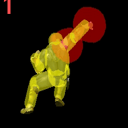

In [36]:
imagizer(colorData[100][2][:, 10, : ,: ].to(torch.uint8))

In [10]:
colorDf = pd.DataFrame(colorData, columns=['Name', 'Move', 'Tensor'])
colorDf.to_pickle('colorData.pkl')

# Merging grayscale images with the list of damages

In [5]:
df1 = pd.DataFrame(charMoveTensor, columns=['Character', 'Move', 'Tensor'])
df1.to_pickle('moveFrameData.pkl')

Due to the way the filenames were stored on the website we scraped from, we are going to have to merge character names that were formatted in two different ways. Let's take a look at the formatting and see if we can discern a pattern.

In [7]:
df2 = pd.read_pickle('moveDamages.pkl')
l1 = df1['Character'].unique()
l2 = df2['Character'].unique()
print(l1, l2)

['bowser' 'captain_falcon' 'donkey_kong' 'dr._mario' 'falco' 'fox'
 'ganondorf' 'ice_climbers' 'jigglypuff' 'kirby' 'link' 'luigi' 'mario'
 'marth' 'mewtwo' 'mr._game_&_watch' 'ness' 'peach' 'pichu' 'pikachu'
 'roy' 'samus' 'sheik' 'yoshi' 'young_link' 'zelda' 'zelda_old'] ['CAPTAIN FALCON' 'DONKEY KONG' 'DR. MARIO' 'FALCO' 'FOX' 'GANONDORF'
 'ICE CLIMBERS' 'KIRBY' 'BOWSER' 'LINK' 'LUIGI' 'MARIO' 'MARTH' 'MEWTWO'
 'MR. GAME & WATCH' 'NESS' 'PEACH' 'PICHU' 'PIKACHU' 'JIGGLYPUFF' 'ROY'
 'SAMUS' 'SHEIK' 'YOSHI' 'YOUNG LINK' 'ZELDA']


While the character name is structured enough to have an algorithmically created dictionary, the move names require a manually compiled dictionary.

In [ ]:
charNameDict = {lowerName: lowerName.upper().replace('_', ' ') for lowerName in l1}

In [9]:
moveDictionary = {'jab1': 'Jab', 'jab2': 'Jab 2', 'jab3': 'Jab 3', 'ftilt': 'Forward Tilt', 'utilt': 'Up Tilt', 'dtilt': 'Down Tilt',
                    'dattack': 'Dash Attack', 'fsmash': 'Forward Smash', 'usmash': 'Up Smash', 'dsmash': 'Down Smash', 'nair': 'Neutral Air',
                    'fair': 'Forward Air', 'bair': 'Back Air', 'uair': 'Up Air', 'dair': 'Down Air', 'neutralb': 'Neutral B', 'a-neutralb': 'Aerial Neutral B',
                    'sideb': 'Side B', 'a-sideb': 'Aerial Side B', 'upb': 'Up B', 'a-upb': 'Aerial Up B', 'downb': 'Down B', 'a-downb': 'Aerial Down B',
                    'rapidjab': 'Rapid Jab'}

In [10]:
df1['Character'] = df1['Character'].map(charNameDict)
df1['Move'] = df1['Move'].map(moveDictionary)
df2['Damage'] = df2['Damage'].astype('float32')

We again need to sanitize the dataset from moves which deal 0 damage.

In [11]:
df2.sort_values(by='Damage', ascending=True).head(3)

,Character,Move,Damage
508,ZELDA,Down B,0.0
262,MARTH,Side B,0.0
281,MEWTWO,Up B,0.0


In [14]:
df1.dropna(inplace=True)
df1.shape

(498, 3)

In [15]:
merged_df = pd.merge(df1, df2, on=['Character', 'Move'], how='inner')
merged_df.columns
merged_df.describe()

,Damage
count,476.000000
mean,11.058824
std,10.654220
min,0.000000
25%,6.000000
50%,11.000000
75%,14.000000
max,200.000000


In [16]:
merged_df = merged_df.loc[(merged_df['Damage'] !=0)]
merged_df.describe()

Now let's address any large outliers.

In [18]:
merged_df.drop('Tensor', axis=1).sort_values(by= 'Damage', ascending=False).head()

,Character,Move,Damage
285,MR. GAME & WATCH,Down B,200.0
374,ROY,Neutral B,50.0
312,NESS,Neutral B,36.0
132,GANONDORF,Neutral B,34.0
54,DONKEY KONG,Neutral B,30.0


In [ ]:
merged_df = merged_df.drop(285)
merged_df = merged_df.reset_index()

We can now export the dataset.

In [24]:
merged_df.to_pickle('processedDataset.pkl')